In [1]:
import numpy as np

# Load adversarial
train = np.load('adversarial_example/generated/train_set.npz')
x_train_adv, y_train_adv = train['x'], train['y']

test = np.load('adversarial_example/generated/test_set.npz')
x_test_adv, y_test_adv = test['x'], test['y']

In [2]:
# Load Real data
train = np.load('adversarial_example/raw/train_set.npz')
x_train, y_train = train['x'], train['y']

test = np.load('adversarial_example/raw/test_set.npz')
x_test, y_test = test['x'], test['y']

In [3]:
label_format_real = ['paper', 'rock', 'scissors']
label_format_adv = ['real', 'white-box', 'black-box']

In [4]:
print("Train Adversarial Image shape : {}".format(x_train_adv.shape))
print("Test Adversarial Image shape : {}".format(x_test_adv.shape))

Train Adversarial Image shape : (3171, 128, 128, 3)
Test Adversarial Image shape : (2121, 128, 128, 3)


Label : 1. black-box
Label : 2. black-box
Label : 3. black-box
Label : 4. white-box
Label : 5. black-box
Label : 6. white-box
Label : 7. black-box
Label : 8. black-box
Label : 9. white-box
Label : 10. white-box
Label : 11. white-box
Label : 12. black-box


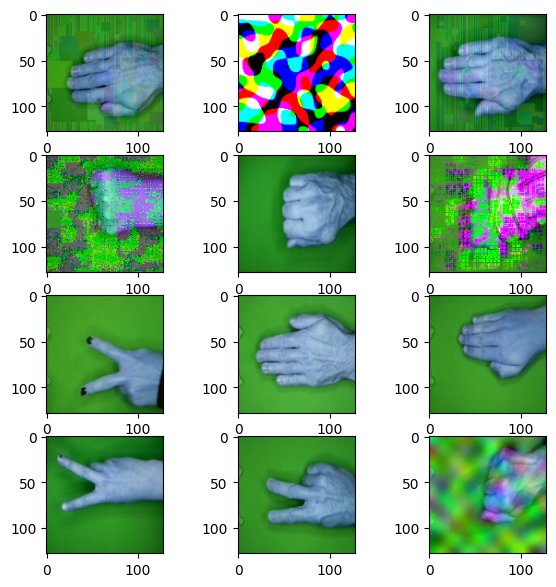

In [5]:
import random
import matplotlib.pyplot as plt

# Display Some image sample
width = 4
height = 3
total_image = width * height

# Get random
rand_idx_list = random.sample(range(len(y_train_adv)), total_image)

fig_idx = 1
fig = plt.figure(figsize=(7, 7))
randomed_label = []
for idx in rand_idx_list:
    fig.add_subplot(width, height, fig_idx)
    plt.imshow(x_train_adv[idx])
    randomed_label.append((y_train_adv[idx], fig_idx))
    fig_idx += 1

for label in randomed_label:
    print("Label : {}. {}".format(label[1], label_format_adv[label[0]]))

In [6]:
from collections import Counter

def calculate_distribution(y):
    n_class = []
    counter = Counter(y)
    for k, v in counter.items():
        per= v / len(y) * 100
        n_class.append(v)
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

    return n_class

print("Train Adversarial distribution : ")
training_n_class = calculate_distribution(y_train_adv)
print("Test Adversarial distribution : ")
testing_n_class = calculate_distribution(y_test_adv)

mean_class_distribution = sum(training_n_class) / len(training_n_class)
print("Mean data to sample from training data : {}".format(mean_class_distribution))

Train Adversarial distribution : 
Class=1, n=1812 (57.143%)
Class=2, n=1359 (42.857%)
Test Adversarial distribution : 
Class=1, n=1212 (57.143%)
Class=2, n=909 (42.857%)
Mean data to sample from training data : 1585.5


In [7]:
# Sampling training data as label 0
x_train_sampled = x_train[:int(mean_class_distribution)]

# Generate 0 label
y_train_sampled = np.zeros(len(x_train_sampled))
y_test_sampled = np.zeros(len(x_test))

In [8]:
# Merge into one array 
main_x_train, main_x_test = [], []
main_y_train, main_y_test = [], []

# Begin with train x and y
x_train_adv_list, y_train_adv_list = x_train_adv.tolist(), y_train_adv.tolist()
x_train_sampled_list, y_train_sampled_list = x_train_sampled.tolist(), y_train_sampled.tolist()
main_x_train.extend(x_train_adv_list)
main_x_train.extend(x_train_sampled_list)
main_y_train.extend(y_train_adv_list)
main_y_train.extend(y_train_sampled_list)

# Then with test x and y
x_test_adv_list, y_test_adv_list = x_test_adv.tolist(), y_test_adv.tolist()
x_test_sampled_list, y_test_sampled_list = x_test.tolist(), y_test_sampled.tolist()
main_x_test.extend(x_test_adv_list)
main_x_test.extend(x_test_sampled_list)
main_y_test.extend(y_test_adv_list)
main_y_test.extend(y_test_sampled_list)

In [9]:
# Convert to numpy again
main_x_train, main_y_train = np.array(main_x_train), np.array(main_y_train)
main_x_test, main_y_test = np.array(main_x_test), np.array(main_y_test)

In [10]:
print("Train distribution : ")
training_n_class = calculate_distribution(main_y_train)
print("Test distribution : ")
testing_n_class = calculate_distribution(main_y_test)

Train distribution : 
Class=1, n=1812 (38.099%)
Class=2, n=1359 (28.574%)
Class=0, n=1585 (33.326%)
Test distribution : 
Class=1, n=1212 (45.427%)
Class=2, n=909 (34.070%)
Class=0, n=547 (20.502%)


In [11]:
import cv2

def flip(img, preference='horizontal'):
    if preference == 'horizontal':
        return cv2.flip(img, 1)
    if preference == 'vertical':
        return cv2.flip(img, 0)
    
def brightness(img, brightness_value=0.05):
    if brightness_value != 0:
        if brightness_value > 0:
            shadow = brightness_value
            highlight = 1
        else:
            shadow = 0
            highlight = 1 + brightness_value
        alpha_b = (highlight - shadow)/1
        gamma_b = shadow
        buf = cv2.addWeighted(img, alpha_b, img, 0, gamma_b)
    else:
        buf = img.copy()

    return buf

def gaussian_blur(img, kernel_size=(3, 3), intensity=0.1):
    return cv2.GaussianBlur(img, kernel_size, intensity)

augmented_x_train = []
augmented_y_train = []

# Apply augmentation for each data
for idx, x in enumerate(main_x_train):
    # Brightness changes
    augmented_x_train.append(cv2.resize(brightness(x, brightness_value=-0.2), (128, 128)))
    augmented_y_train.append(main_y_train[idx])
    augmented_x_train.append(cv2.resize(brightness(x, brightness_value=0.2), (128, 128)))
    augmented_y_train.append(main_y_train[idx])

    # Flip changes
    augmented_x_train.append(cv2.resize(flip(x, preference='vertical'), (128, 128)))
    augmented_y_train.append(main_y_train[idx])
    augmented_x_train.append(cv2.resize(flip(x, preference='horizontal'), (128, 128)))
    augmented_y_train.append(main_y_train[idx])

    # Gaussian Blur
    augmented_x_train.append(cv2.resize(gaussian_blur(x, kernel_size=(3, 3), intensity=0), (128, 128)))
    augmented_y_train.append(main_y_train[idx])
    augmented_x_train.append(cv2.resize(gaussian_blur(x, kernel_size=(5, 5), intensity=0), (128, 128)))
    augmented_y_train.append(main_y_train[idx])

In [12]:
# Include the augmented data
final_x_train, final_y_train = [], []

main_x_train_list, main_y_train_list = main_x_train.tolist(), main_y_train.tolist()
final_x_train.extend(main_x_train_list)
final_x_train.extend(augmented_x_train)
final_y_train.extend(main_y_train_list)
final_y_train.extend(augmented_y_train)

final_x_train, final_y_train = np.array(final_x_train), np.array(final_y_train)

In [13]:
print("Final Train distribution : ")
training_n_class = calculate_distribution(final_y_train)
print("Final Test distribution : ")
testing_n_class = calculate_distribution(main_y_test)

Final Train distribution : 
Class=1, n=12684 (38.099%)
Class=2, n=9513 (28.574%)
Class=0, n=11095 (33.326%)
Final Test distribution : 
Class=1, n=1212 (45.427%)
Class=2, n=909 (34.070%)
Class=0, n=547 (20.502%)


In [14]:
import tensorflow as tf

# Encode both labels
final_y_train = tf.keras.utils.to_categorical(final_y_train, num_classes=3)
main_y_test = tf.keras.utils.to_categorical(main_y_test, num_classes=3)

In [15]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.summary()

    return model

model = create_model(input_shape=(final_x_train.shape[1], final_x_train.shape[2], final_x_train.shape[3]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       19456     
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       1638656   
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       1638656   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         295040    
                                                        

In [16]:
LEARNING_RATE = 0.001
LEARNING_RATE_AFTER = 0.0005
OPTIMIZER = 'ADAM'
EPOCHS = 60
BATCH_SIZE = 64

In [17]:
def scheduler(epoch):
    if epoch < 60:
        return LEARNING_RATE
    else:
        return LEARNING_RATE_AFTER
    
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler(0)),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
with tf.device('/gpu:0'):
    history = model.fit(
        x=final_x_train,
        y=final_y_train,
        validation_data=(main_x_test, main_y_test),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[scheduler_callback]
    )

Epoch 1/60
521/521 [==============================] - 47s 69ms/step - loss: 0.9749 - accuracy: 0.4837 - val_loss: 0.9525 - val_accuracy: 0.4220 - lr: 0.0010
Epoch 2/60
521/521 [==============================] - 666s 1s/step - loss: 0.9201 - accuracy: 0.5405 - val_loss: 0.9387 - val_accuracy: 0.4921 - lr: 0.0010
Epoch 3/60
521/521 [==============================] - 1035s 2s/step - loss: 0.7691 - accuracy: 0.6260 - val_loss: 0.7017 - val_accuracy: 0.6023 - lr: 0.0010
Epoch 4/60
521/521 [==============================] - 1031s 2s/step - loss: 0.7175 - accuracy: 0.6531 - val_loss: 0.7417 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 5/60
521/521 [==============================] - 1027s 2s/step - loss: 0.7040 - accuracy: 0.6646 - val_loss: 0.6609 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 6/60
521/521 [==============================] - 1030s 2s/step - loss: 0.6990 - accuracy: 0.6710 - val_loss: 0.6813 - val_accuracy: 0.6338 - lr: 0.0010
Epoch 7/60
521/521 [==============================] - 1018s

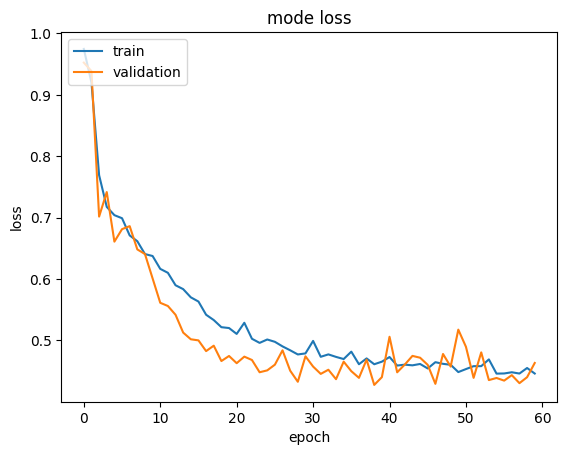

In [20]:
import matplotlib.pyplot as plt

# Save Train result
fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mode loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

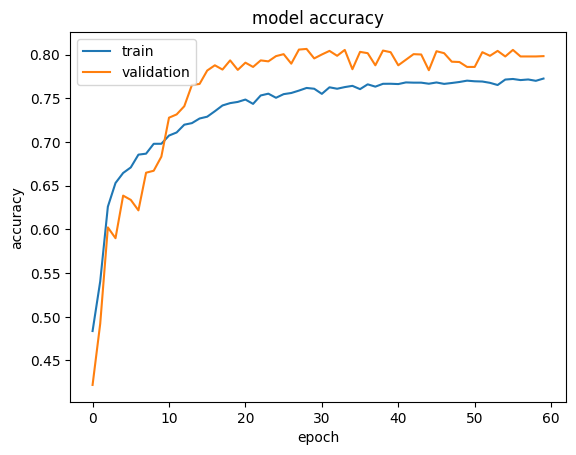

In [21]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
training_conf = {
    'labels_string':label_format_adv,
    'labels_encoded':[0, 1, 2],
    'learning_rate':LEARNING_RATE,
    'learning_rate_scheduler':LEARNING_RATE_AFTER,
    'epochs':EPOCHS,
    'batch_size':BATCH_SIZE,
    'model_summary':str(model.summary())
}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       19456     
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       1638656   
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       1638656   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         295040    
                                                        

In [23]:
import os
import json

save_name = 'trained_cnn_v1.16_adversary_example'
def save_model(model, model_accuracy, model_loss, training_conf, save_folder):
    # Creating the folder if doesnt exist and vice versa
    save_folder_path = os.path.join('weight', save_folder)
    if not os.path.exists(save_folder_path):
        os.makedirs(save_folder_path)

    model_loss.savefig(os.path.join(save_folder_path, 'training_loss.jpg'))
    model_accuracy.savefig(os.path.join(save_folder_path, 'training_accuracy.jpg'))
    model.save_weights(os.path.join(save_folder_path, 'weight.h5'))
    model.save(os.path.join(save_folder_path, 'conf_weight.h5'))

    with open(os.path.join(save_folder_path, 'training_conf.json'), 'w') as f:
        json.dump(training_conf, f, indent=4)

In [24]:
save_model(model=model, model_accuracy=fig, model_loss=fig1, training_conf=training_conf, save_folder=save_name)